# Data Collection

In [ ]:
%%capture
pip install praw

In [ ]:
%%capture
pip install gensim

In [ ]:
!pip install numpy==1.24.3
!pip install --upgrade gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3

In [ ]:
# import libraries and download necessary nltk resources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("vader_lexicon")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# import praw
import praw

# enter reddit username, client_id, client secret
user_agent = ""
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    user_agent=user_agent,
    check_for_async=False
)

# select subreddit
subreddit = reddit.subreddit("cars+electricvehicles")

# define keywords
keywords_1 = ["EV", "EVs"]
keywords_2 = ["electric", "electric car", "electric vehicle", "electric truck", "phev", "plug-in hybrid", "plug-in ev"]

In [ ]:
# fetch top posts from last year about EVs
data = []

for submission in subreddit.top(time_filter="year", limit=None):
  title = submission.title
  id = submission.id # stores post ID
  subreddit_name = submission.subreddit.display_name # stores subreddit name

  # post filtering via keywords
  if (any(keyword in title for keyword in keywords_1) or
      any(keyword in title.lower() for keyword in keywords_2)):

      data.append({
          "post_id": id,
          "subreddit": subreddit_name,
          "text_type": "headline",
          "text": title
      })

    # fetch comments
      submission.comments.replace_more(limit=0)
      for comment in submission.comments:
        # skip short comments
        if len(comment.body) > 20:
          data.append({
            "post_id": id,
            "subreddit": subreddit_name,
            "text_type": "comment",
            "text": comment.body
          })

print(len(data))


25253


In [ ]:
# export to DataFrame
df = pd.DataFrame(data)

# to csv
df.to_csv("reddit_ev_posts_comments.csv", encoding="utf-8", index=False)

In [ ]:
# Approximate length or average number of words per post/comment
df.text.str.split().str.len().mean()

np.float64(41.71448936759989)

In [ ]:
df.describe()
df

,post_id,subreddit,text_type,text
0,1eka10c,electricvehicles,headline,Trump says he has 'no choice' but to support e...
1,1eka10c,electricvehicles,comment,"So, he’s admitting he can be bought off? Shock..."
2,1eka10c,electricvehicles,comment,1. He’s admitting that he can be bought and pa...
3,1eka10c,electricvehicles,comment,No policy. No rationale about efficiency and ...
4,1eka10c,electricvehicles,comment,"""Trump then went on to criticize the EV indust..."
...,...,...,...,...
25248,1c0lnsj,electricvehicles,comment,And yet if you buy a decent ebike you can get ...
25249,1c0lnsj,electricvehicles,comment,Per gallon of what? Electrogallons
25250,1c0lnsj,electricvehicles,comment,Most EVs I‘ve driven used 0 gallons per mile… ...
25251,1c0lnsj,electricvehicles,comment,My car can go 5808 football fields


# Data Cleaning and Preprocessing

In [ ]:
df = pd.read_csv("/reddit_ev_posts_comments.csv")
df.info()

# drop duplicates if they appear in the same subreddit
df.drop_duplicates(subset=["text", "subreddit"], inplace=True)

# drop NaN values
df.dropna(subset=["text"],inplace=True)

# removing spaces
df["text"] = df["text"].str.strip()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25955 entries, 0 to 25954
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post_id    25955 non-null  object
 1   subreddit  25955 non-null  object
 2   text_type  25955 non-null  object
 3   text       25955 non-null  object
dtypes: object(4)
memory usage: 811.2+ KB


In [ ]:
# deleting urls
def delete_url(text):
  return re.sub(r"http\S+|https\S+|www\S+", "", text)

df["text"] = df["text"].apply(delete_url)



In [ ]:
# removing unwanted tokens and punctuation
df["tokens"] = df["text"].apply(lambda x: [w for w in nltk.word_tokenize(str(x).lower()) if w.isalpha()])

print(df.head())
df.info()


   post_id         subreddit text_type  \
0  1gipv0h  electricvehicles  headline   
1  1gipv0h  electricvehicles   comment   
2  1gipv0h  electricvehicles   comment   
3  1gipv0h  electricvehicles   comment   
4  1gipv0h  electricvehicles   comment   

                                                text  \
0             Spotted this great EV charging station   
1  Just saw this tweet \n\nAnd yes this should be...   
2  Facts! As a new EV owner, I am so tired of dow...   
3  Those prices!! For the equivalent of £0.32/kWh...   
4  Why is everyone commenting on the prices? Isn'...   

                                              tokens  
0      [spotted, this, great, ev, charging, station]  
1  [just, saw, this, tweet, and, yes, this, shoul...  
2  [facts, as, a, new, ev, owner, i, am, so, tire...  
3  [those, prices, for, the, equivalent, of, when...  
4  [why, is, everyone, commenting, on, the, price...  
<class 'pandas.core.frame.DataFrame'>
Index: 25912 entries, 0 to 25954
Data colu

# Sentiment Analysis

In [ ]:
# import sentiment analysis class
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# create sentiment analysis instance
sid = SentimentIntensityAnalyzer()

# generate sentiment scores and column
sentiment_scores = df["text"].apply(sid.polarity_scores)
print(sentiment_scores)

df["sentiment_scores"] = sentiment_scores

# extract the compund score using lambda function
df["compound_score"] = df["sentiment_scores"].apply(lambda x: x["compound"])

# assigning sentiment label based on sentiment score
def label_sentiment(compound):
  if compound >= 0.05:
    return "positive"
  elif compound <= -0.05:
    return "negative"
  else:
    return "neutral"

# create label column
sentiment_label = df["compound_score"].apply(label_sentiment)
df["sentiment_label"] = sentiment_label

df.head()



0        {'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp...
1        {'neg': 0.16, 'neu': 0.679, 'pos': 0.16, 'comp...
2        {'neg': 0.175, 'neu': 0.825, 'pos': 0.0, 'comp...
3        {'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'comp...
4        {'neg': 0.066, 'neu': 0.784, 'pos': 0.15, 'com...
                               ...                        
25950    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
25951    {'neg': 0.049, 'neu': 0.844, 'pos': 0.107, 'co...
25952    {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...
25953    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
25954    {'neg': 0.0, 'neu': 0.92, 'pos': 0.08, 'compou...
Name: text, Length: 25912, dtype: object


,post_id,subreddit,text_type,text,tokens,sentiment_scores,compound_score,sentiment_label
0,1gipv0h,electricvehicles,headline,Spotted this great EV charging station,"[spotted, this, great, ev, charging, station]","{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp...",0.6249,positive
1,1gipv0h,electricvehicles,comment,Just saw this tweet \n\nAnd yes this should be...,"[just, saw, this, tweet, and, yes, this, shoul...","{'neg': 0.16, 'neu': 0.679, 'pos': 0.16, 'comp...",0.0000,neutral
2,1gipv0h,electricvehicles,comment,"Facts! As a new EV owner, I am so tired of dow...","[facts, as, a, new, ev, owner, i, am, so, tire...","{'neg': 0.175, 'neu': 0.825, 'pos': 0.0, 'comp...",-0.6166,negative
3,1gipv0h,electricvehicles,comment,Those prices!! For the equivalent of £0.32/kWh...,"[those, prices, for, the, equivalent, of, when...","{'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'comp...",0.5231,positive
4,1gipv0h,electricvehicles,comment,Why is everyone commenting on the prices? Isn'...,"[why, is, everyone, commenting, on, the, price...","{'neg': 0.066, 'neu': 0.784, 'pos': 0.15, 'com...",0.4408,positive


# Data Visualization

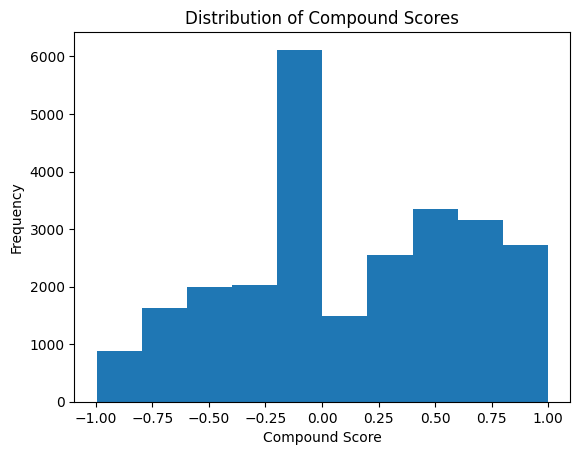

In [ ]:
# compound distribution
plt.hist(df["compound_score"], bins=10)
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.title("Distribution of Compound Scores")
plt.show()

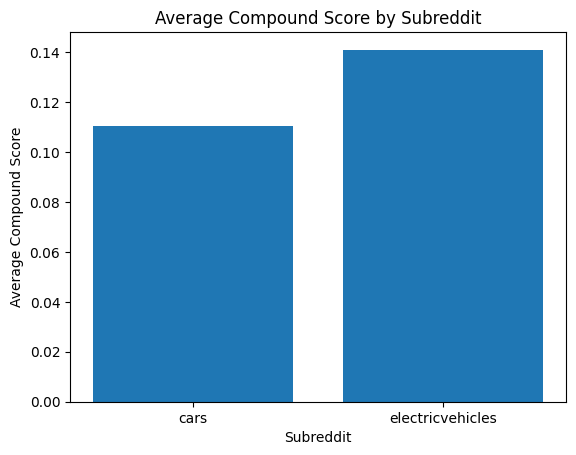

In [ ]:
# average compound by sub
sub_sentiment = df.groupby("subreddit")["compound_score"].mean()

plt.bar(sub_sentiment.index, sub_sentiment.values)
plt.xlabel("Subreddit")
plt.ylabel("Average Compound Score")
plt.title("Average Compound Score by Subreddit")
plt.show()

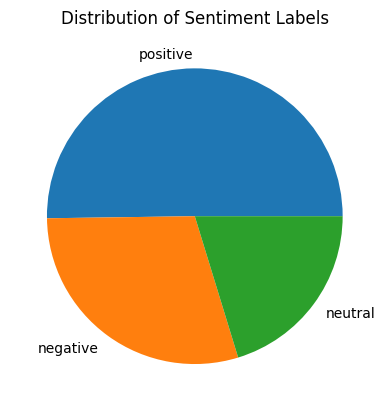

In [ ]:
# distribution of sentiment labels
label_counts = df["sentiment_label"].value_counts()
plt.pie(label_counts.values, labels=label_counts.index)
plt.title("Distribution of Sentiment Labels")
plt.show()


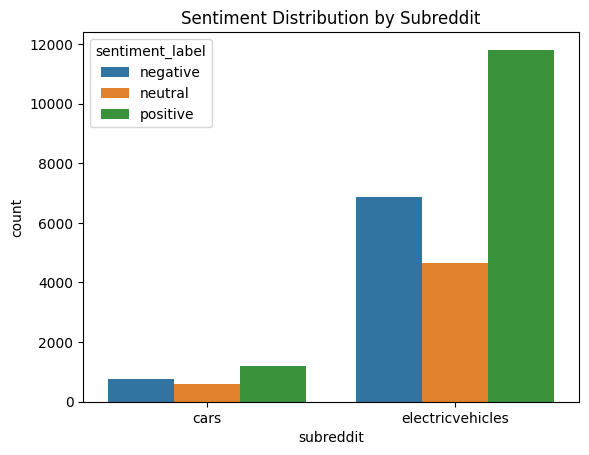

In [ ]:
# distribution of labels by sub
grouped_sentiment = df.groupby(["subreddit", "sentiment_label"]).size().reset_index(name="count")
sns.barplot(x="subreddit", y="count", hue="sentiment_label", data=grouped_sentiment)
plt.title("Sentiment Distribution by Subreddit")
plt.show()



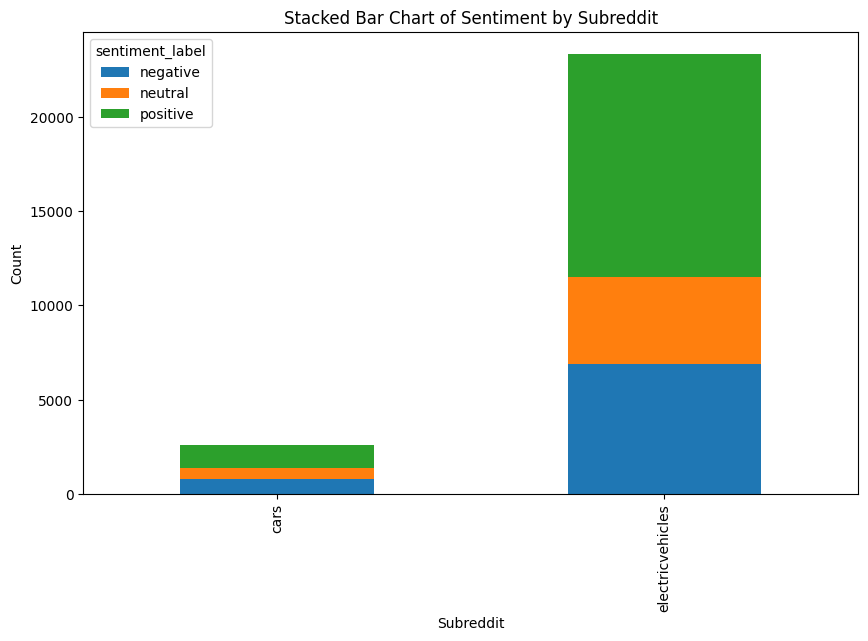

In [ ]:
# sentiment by sub stacked
grouped = df.groupby(["subreddit", "sentiment_label"]).size().unstack(fill_value=0)
grouped.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Stacked Bar Chart of Sentiment by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.show()


# WordCloud

<function matplotlib.pyplot.show(close=None, block=None)>

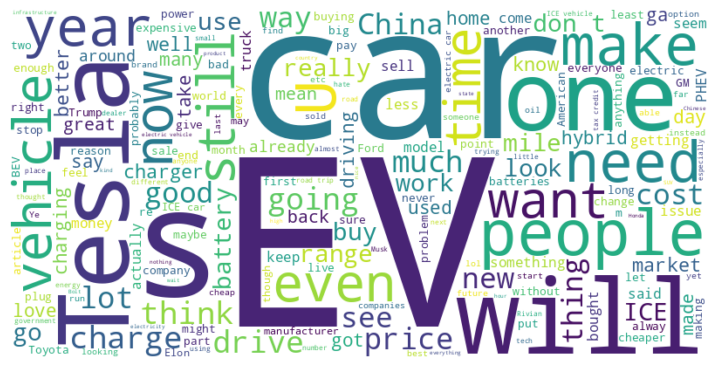

In [ ]:
# generate wordcloud
from wordcloud import WordCloud, STOPWORDS

combined_text = " ".join(df["text"])

word_cloud = WordCloud(background_color="white", width=800, height=400, stopwords = STOPWORDS).generate(combined_text)

# display wordcloud
plt.figure(figsize=(9,8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show

## Topic Modelling
Applying Latent Dirichlet Allocation (LDA) model using gensim for topic analysis and modelling.

In [ ]:
# import necessary libraries for topic modelling
nltk.download("wordnet")
nltk.download("stopwords")
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import random
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# set random seed for reproducability
random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# lemmatization and stopword removal for tokenized text

english_stops = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

# preprocessing for topic modelling
def preprocess_topic(tokens):

  # remove stopwords
  no_stops = [t for t in tokens if t not in english_stops]

  #lemmatize tokens
  lemmatized = [lemmatizer.lemmatize(t) for t in no_stops]

  return lemmatized

# update tokens column
df = df.sort_values(by="text").reset_index(drop=True)  # enforce deterministic ordering
df["tokens"] = df["tokens"].apply(preprocess_topic)

# dictionary and creating gensim corpus for LDA
dictionary = corpora.Dictionary(df["tokens"])
dictionary.save("lda_dictionary.dict") # saves dictionary


corpus = [dictionary.doc2bow(text) for text in df["tokens"]] # list of BoW representation
corpora.MmCorpus.serialize("lda_corpus.mm", corpus) # this avoids recomputing BoW every run

# load (for consistency in future runs)
dictionary = corpora.Dictionary.load("lda_dictionary.dict")
corpus = corpora.MmCorpus("lda_corpus.mm")

# define the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=4,
                                            passes=10,
                                            random_state=42,
                                            per_word_topics=True,
                                            minimum_probability=0.0
                                            )

# print the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
  print(topic)

# evaluate coherence score to determine optimal number of topics
coherence_model = CoherenceModel(model=lda_model, texts=df["tokens"], dictionary=dictionary, coherence="c_v")
coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)

(0, '0.021*"ev" + 0.017*"charging" + 0.015*"car" + 0.012*"people" + 0.012*"charge" + 0.011*"charger" + 0.010*"gas" + 0.010*"get" + 0.009*"time" + 0.009*"need"')
(1, '0.023*"battery" + 0.022*"ev" + 0.021*"car" + 0.015*"cost" + 0.012*"year" + 0.012*"vehicle" + 0.011*"ice" + 0.011*"price" + 0.007*"new" + 0.007*"much"')
(2, '0.030*"ev" + 0.014*"tesla" + 0.014*"u" + 0.010*"market" + 0.009*"company" + 0.009*"china" + 0.008*"car" + 0.007*"people" + 0.007*"sale" + 0.006*"make"')
(3, '0.022*"car" + 0.020*"ev" + 0.017*"like" + 0.014*"one" + 0.011*"model" + 0.009*"year" + 0.008*"look" + 0.008*"get" + 0.008*"would" + 0.006*"want"')
Coherence Score: 0.6381800221531038


# Visualize LDA with pyLDAvis

In [ ]:
%%capture
!pip install pyLDAvis

In [ ]:
# create interactive visualization with pyLDAvis
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# save as html
pyLDAvis.save_html(lda_display, "topic_modelling_vis.html")
